# Exploratory Data Exploration

This project is aimed at predicting the case of customers default payments in Taiwan.

## Questions to answer

* What is the shape of the dataset?
* Is the target class balanced or imbalanced?
* Are there any data quality issues, such as missing values, duplicates, or inconsistent entries?
* What correlations are there?
* Are there any outliers?
* What are the baseline scores if we naively assume predictions are the majority class?

## Findings

* There are 30,000 records and 23 features.
There are no missing / null values
* There are 14 counts of mislabelled education. These will be converted to unknown.
* There are 54 instances of incorrect labelling of marriage. These records will be converted to the other category.
* For the `PAY_0`, ..., `PAY_6` columns, there are two additional labels `-2` and `0` that are undocumented in the metadata. From reading the documentation, these labels should be labelled as paid duly.
* there are more women than men
* men are more likely to default the next month
* married people are most likely to default, followed by the `Other` group
* There are customers that have first appear in the dataset at a later month, as they have 0 in BILL and PAY AMT for several months, before they have transactions. 
* Divorced men are most likely to default, followed by married men.
* The credit card balance can have negative amounts, which means that the bank owes the account holder money.
* The negative balance will become zero or a positive balance as the cardholder charges additional purchases. 
* Customers with high PAY AMOUNT are less likely to default than those with low PAY AMOUNT.

TODOs

* Rename column names to be more descriptive
* Rename categorical variables
* For `MARRIAGE` feature, convert 54 instances with label `0` to label `3`
* Apply one-hot encoding to categorical variables, N-1 to reduce multicollinearity
* Convert data types 
* Clean the data
* Apply feature scaling to numerical data
    * Standardisation (Z-score normalisation) - as it is more robust to outliers compared to other scaling techniques, such as Min-Max Scaling
* Create new features with feature engineering
* Apply feature transformations, e.g. log transformations on highly skewed data
* Apply feature selection
* Apply SMOTE to balance the classes

NOTE: Ensure preprocessing steps are only applied to training splits to avoid data leakage.


In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

%matplotlib inline
sns.set_style("whitegrid")
sns.set_palette("colorblind")
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
data_path = "../data/raw/credit_card_default.csv"
df = pd.read_csv(data_path)

In [3]:
df.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


In [4]:
df.shape

(30000, 25)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [6]:
df.describe().T.style.background_gradient(
    subset=["mean", "std", "50%", "count"], cmap="RdPu"
)

,count,mean,std,min,25%,50%,75%,max
ID,30000.000000,15000.500000,8660.398374,1.000000,7500.750000,15000.500000,22500.250000,30000.000000
LIMIT_BAL,30000.000000,167484.322667,129747.661567,10000.000000,50000.000000,140000.000000,240000.000000,1000000.000000
SEX,30000.000000,1.603733,0.489129,1.000000,1.000000,2.000000,2.000000,2.000000
EDUCATION,30000.000000,1.853133,0.790349,0.000000,1.000000,2.000000,2.000000,6.000000
MARRIAGE,30000.000000,1.551867,0.521970,0.000000,1.000000,2.000000,2.000000,3.000000
AGE,30000.000000,35.485500,9.217904,21.000000,28.000000,34.000000,41.000000,79.000000
PAY_0,30000.000000,-0.016700,1.123802,-2.000000,-1.000000,0.000000,0.000000,8.000000
PAY_2,30000.000000,-0.133767,1.197186,-2.000000,-1.000000,0.000000,0.000000,8.000000
PAY_3,30000.000000,-0.166200,1.196868,-2.000000,-1.000000,0.000000,0.000000,8.000000
PAY_4,30000.000000,-0.220667,1.169139,-2.000000,-1.000000,0.000000,0.000000,8.000000


### Check for missing values

In [7]:
# find out % of missing values for each column
missing_proportion = df.isnull().sum() / len(df) * 100
print(missing_proportion)

ID                            0.0
LIMIT_BAL                     0.0
SEX                           0.0
EDUCATION                     0.0
MARRIAGE                      0.0
AGE                           0.0
PAY_0                         0.0
PAY_2                         0.0
PAY_3                         0.0
PAY_4                         0.0
PAY_5                         0.0
PAY_6                         0.0
BILL_AMT1                     0.0
BILL_AMT2                     0.0
BILL_AMT3                     0.0
BILL_AMT4                     0.0
BILL_AMT5                     0.0
BILL_AMT6                     0.0
PAY_AMT1                      0.0
PAY_AMT2                      0.0
PAY_AMT3                      0.0
PAY_AMT4                      0.0
PAY_AMT5                      0.0
PAY_AMT6                      0.0
default.payment.next.month    0.0
dtype: float64


In [8]:
df["default.payment.next.month"].value_counts()

default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64

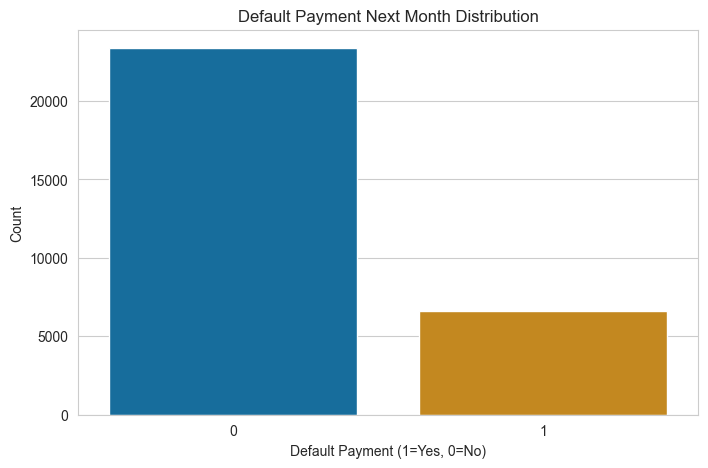

In [9]:
# 7. Default Payment Next Month Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x="default.payment.next.month", data=df)
plt.title("Default Payment Next Month Distribution")
plt.xlabel("Default Payment (1=Yes, 0=No)")
plt.ylabel("Count")
plt.show()

In [10]:
# How unbalanced is the target feature?
target_counts = df.groupby("default.payment.next.month").count().reset_index().iloc[
    :, 1
] / len(df)
print(target_counts)
print(f"Target feature skew: {stats.skew(df['default.payment.next.month'])}")

0    0.7788
1    0.2212
Name: ID, dtype: float64
Target feature skew: 1.3434367747652611


## Baseline

In [11]:
# baseline accuracy, if we assumed every record was positive
base_line_accuracy = 1 - (np.sum(df["default.payment.next.month"]) / df.shape[0])
base_line_accuracy

0.7787999999999999

In [79]:
# check for duplicates
df.duplicated().sum()

0

In [81]:
# check for duplicate ids 
df["id"].duplicated().sum()

0

## Categorical Features - Demographic Factors

### Sex
Gender (1=male, 2=female)


In [12]:
df["SEX"].value_counts()

SEX
2    18112
1    11888
Name: count, dtype: int64

### Education

(1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

In [13]:
df["EDUCATION"].value_counts()

EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64

There are 14 counts of mislabelled education. These will be converted to unknown.

### Marriage

Marital status (1=married, 2=single, 3=others)

In [14]:
df["MARRIAGE"].value_counts()

MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64

There are 54 instances of incorrect labelling of marriage. These records will be converted to the other category.

In [15]:
df["PAY_0"].value_counts()

PAY_0
 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: count, dtype: int64

There are two additional labels `-2` and `0` that are undocumented in the metadata. From reading the documentation, these labels should be labelled as paid duly.

## Rename columns

Rename columns to hold more intuitive and useful names to better understand the data.

In [16]:
new_column_names = {
    "ID": "id",
    "LIMIT_BAL": "credit_limit",
    "SEX": "gender",
    "EDUCATION": "education_level",
    "MARRIAGE": "marital_status",
    "AGE": "age",
    "PAY_0": "repay_status_sep",
    "PAY_2": "repay_status_aug",
    "PAY_3": "repay_status_jul",
    "PAY_4": "repay_status_jun",
    "PAY_5": "repay_status_may",
    "PAY_6": "repay_status_apr",
    "BILL_AMT1": "bill_amt_sep",
    "BILL_AMT2": "bill_amt_aug",
    "BILL_AMT3": "bill_amt_jul",
    "BILL_AMT4": "bill_amt_jun",
    "BILL_AMT5": "bill_amt_may",
    "BILL_AMT6": "bill_amt_apr",
    "PAY_AMT1": "pay_amt_sep",
    "PAY_AMT2": "pay_amt_aug",
    "PAY_AMT3": "pay_amt_jul",
    "PAY_AMT4": "pay_amt_jun",
    "PAY_AMT5": "pay_amt_may",
    "PAY_AMT6": "pay_amt_apr",
    "default.payment.next.month": "default_next_month",
}

# Rename the columns

df = df.rename(columns=new_column_names)

## Remap labels

Remap labels according to the provided metadata to better understand the data.

In [17]:
# Remapping the categorical variables
df["gender"] = df["gender"].map({1: "male", 2: "female"})
df["education_level"] = df["education_level"].map(
    {
        1: "graduate_school",
        2: "university",
        3: "high_school",
        4: "others",
        5: "unknown",
        6: "unknown",
        0: "unknown",
    }
)
df["marital_status"] = df["marital_status"].map(
    {1: "married", 2: "single", 3: "others", 0: "others"}
)

In [18]:
def remap_repayment_status(value):
    if value == -2:
        return "-2_no_consumption"
    elif value == -1:
        return "-1_paid_in_full"
    elif value == 0:
        return "0_paid_minimum"
    elif 1 <= value <= 8:
        return f"delay_{value}_mnths"
    else:
        return "delay_9+_mnths"

In [19]:
# copy list of columns
df["repay_label_sep"] = df["repay_status_sep"]
df["repay_label_aug"] = df["repay_status_aug"]
df["repay_label_jul"] = df["repay_status_jul"]
df["repay_label_jun"] = df["repay_status_jun"]
df["repay_label_may"] = df["repay_status_may"]
df["repay_label_apr"] = df["repay_status_apr"]

In [20]:
# List of columns to apply the remapping
repayment_status_columns = [
    "repay_status_sep",
    "repay_status_aug",
    "repay_status_jul",
    "repay_status_jun",
    "repay_status_may",
    "repay_status_apr",
]

# Apply the remapping function to each column in the list
for column in repayment_status_columns:
    df[column] = df[column].apply(
        lambda x: remap_repayment_status(x)
    )

# Display the first few rows of the DataFrame to verify changes
df[repayment_status_columns].head()

,repay_status_sep,repay_status_aug,repay_status_jul,repay_status_jun,repay_status_may,repay_status_apr
0,delay_2_mnths,delay_2_mnths,-1_paid_in_full,-1_paid_in_full,-2_no_consumption,-2_no_consumption
1,-1_paid_in_full,delay_2_mnths,0_paid_minimum,0_paid_minimum,0_paid_minimum,delay_2_mnths
2,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum
3,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum
4,-1_paid_in_full,0_paid_minimum,-1_paid_in_full,0_paid_minimum,0_paid_minimum,0_paid_minimum


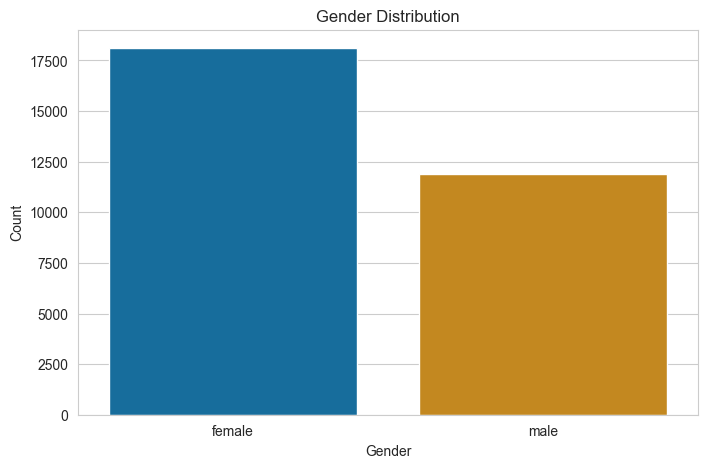

In [21]:
# Gender Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x="gender", data=df)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

In [22]:
df.groupby("default_next_month")["age"].mean()

default_next_month
0    35.417266
1    35.725738
Name: age, dtype: float64

In [23]:
df.groupby("education_level")["default_next_month"].mean()

education_level
graduate_school    0.192348
high_school        0.251576
others             0.056911
university         0.237349
unknown            0.075362
Name: default_next_month, dtype: float64

In [24]:
df.groupby("marital_status")["default_next_month"].mean()

marital_status
married    0.234717
others     0.236074
single     0.209283
Name: default_next_month, dtype: float64

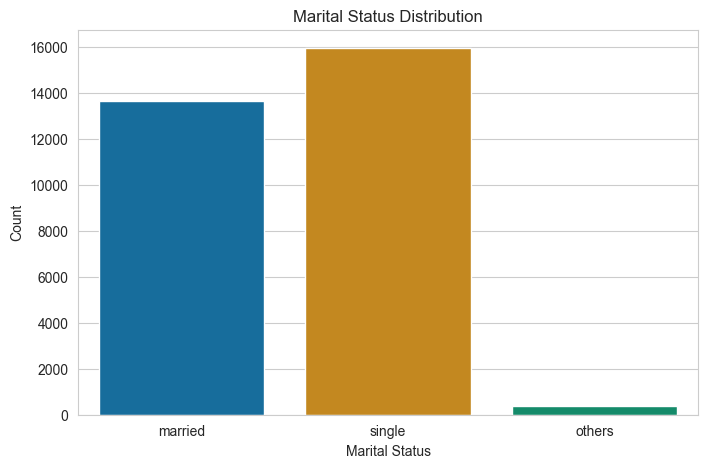

In [25]:
# 5. Marital Status Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x="marital_status", data=df)
plt.title("Marital Status Distribution")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.show()

In [26]:
df.groupby("gender")["default_next_month"].mean()

gender
female    0.207763
male      0.241672
Name: default_next_month, dtype: float64

In [27]:
def boxplot_variation(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width, 6))
    s = sns.boxplot(
        ax=ax1,
        x=feature1,
        y=feature2,
        hue=feature3,
        data=df,
        showfliers=False,
    )
    s.set_xticklabels(s.get_xticklabels(), rotation=90)
    plt.show()

In [28]:
def violinplot_variation(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width, 6))
    s = sns.violinplot(
        ax=ax1,
        x=feature1,
        y=feature2,
        hue=feature3,
        data=df,
        split=True,
    )
    s.set_xticklabels(s.get_xticklabels(), rotation=90)
    plt.show()

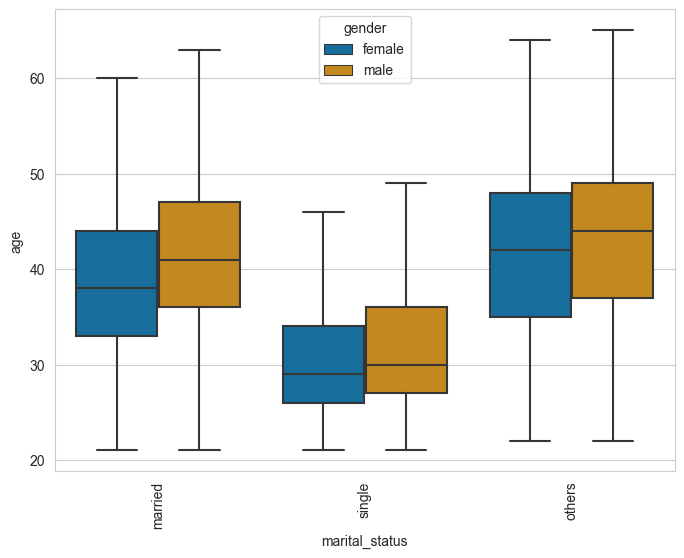

In [29]:
boxplot_variation("marital_status", "age", "gender", 8)

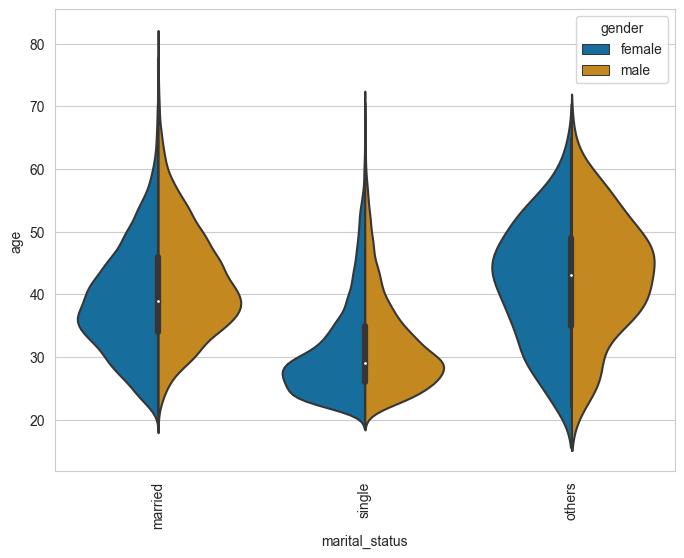

In [30]:
violinplot_variation("marital_status", "age", "gender", 8)

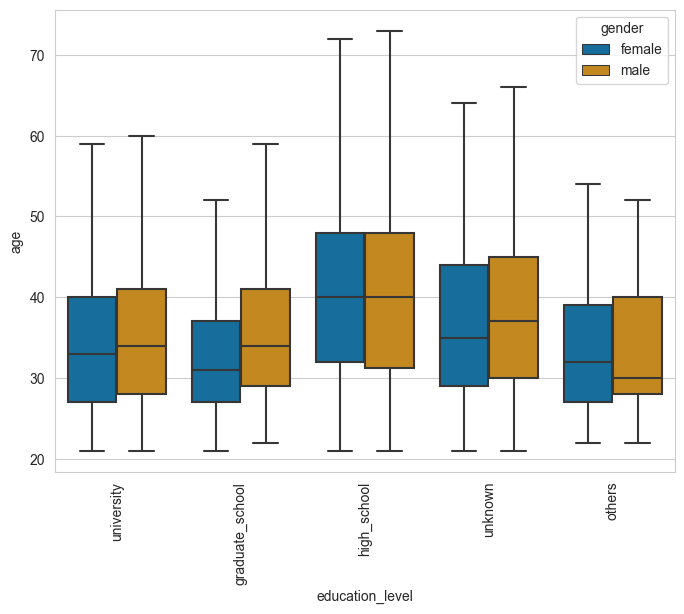

In [31]:
boxplot_variation("education_level", "age", "gender", 8)

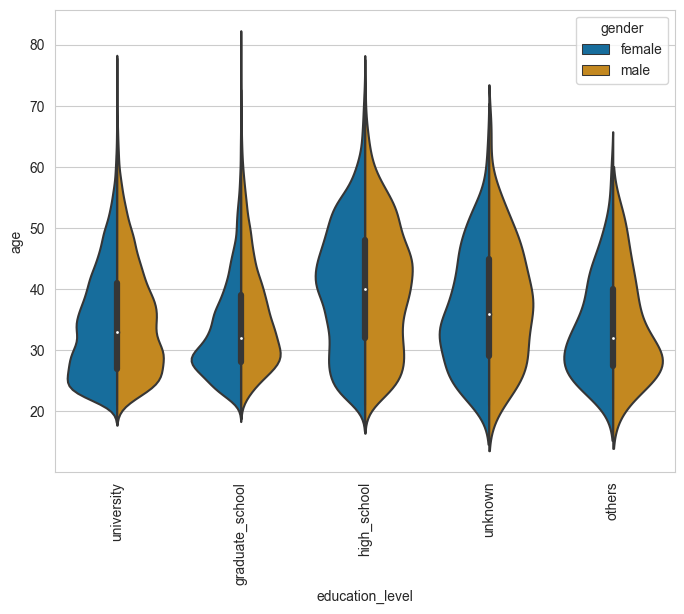

In [32]:
violinplot_variation("education_level", "age", "gender", 8)

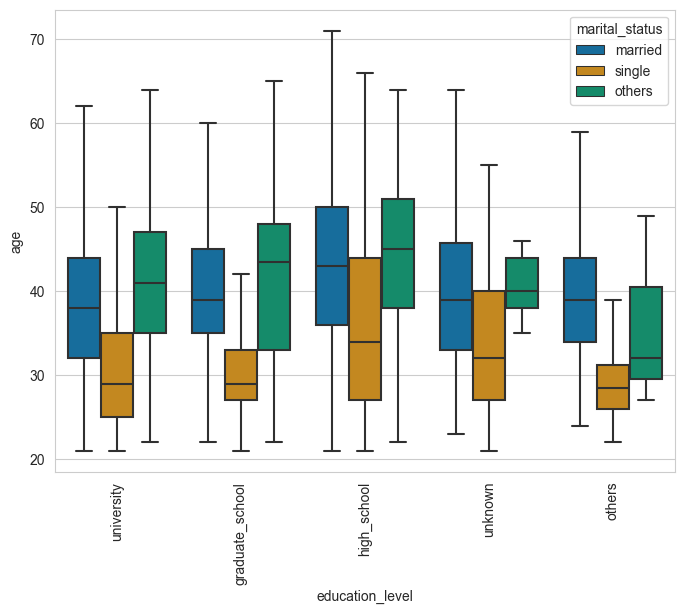

In [33]:
boxplot_variation("education_level", "age", "marital_status", 8)

Is credit limit a numerical or categorical feature?

In [34]:
df.head()

,id,credit_limit,gender,education_level,marital_status,age,repay_status_sep,repay_status_aug,repay_status_jul,repay_status_jun,repay_status_may,repay_status_apr,bill_amt_sep,bill_amt_aug,bill_amt_jul,bill_amt_jun,bill_amt_may,bill_amt_apr,pay_amt_sep,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr,default_next_month,repay_label_sep,repay_label_aug,repay_label_jul,repay_label_jun,repay_label_may,repay_label_apr
0,1,20000.0,female,university,married,24,delay_2_mnths,delay_2_mnths,-1_paid_in_full,-1_paid_in_full,-2_no_consumption,-2_no_consumption,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,2,2,-1,-1,-2,-2
1,2,120000.0,female,university,single,26,-1_paid_in_full,delay_2_mnths,0_paid_minimum,0_paid_minimum,0_paid_minimum,delay_2_mnths,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,-1,2,0,0,0,2
2,3,90000.0,female,university,single,34,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,0,0,0,0,0,0
3,4,50000.0,female,university,married,37,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,0,0,0,0,0,0
4,5,50000.0,male,university,married,57,-1_paid_in_full,0_paid_minimum,-1_paid_in_full,0_paid_minimum,0_paid_minimum,0_paid_minimum,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,-1,0,-1,0,0,0


In [35]:
df.credit_limit.value_counts()

credit_limit
50000.0      3365
20000.0      1976
30000.0      1610
80000.0      1567
200000.0     1528
             ... 
730000.0        2
1000000.0       1
327680.0        1
760000.0        1
690000.0        1
Name: count, Length: 81, dtype: int64

## Numerical features

In [36]:
df["credit_limit"].value_counts().head(5)

credit_limit
50000.0     3365
20000.0     1976
30000.0     1610
80000.0     1567
200000.0    1528
Name: count, dtype: int64

The largest number of credit cards are with limit of 50,000 (3365), followed by 20,000 (1976) and 30,000 (1610).

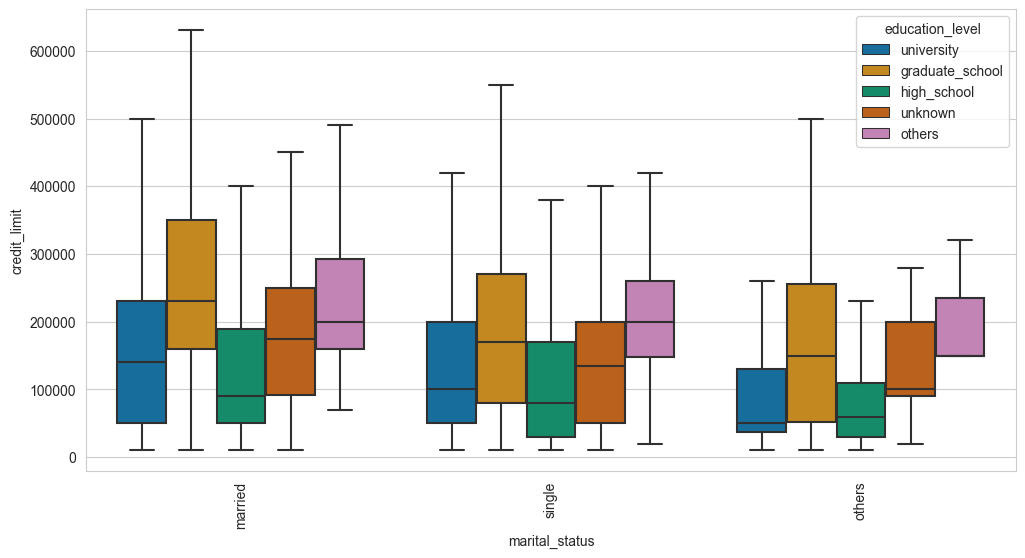

In [37]:
boxplot_variation("marital_status", "credit_limit", "education_level", 12)

### Check if high bill amounts are outliers

In [38]:
df[df.bill_amt_sep > 300000][
    [
        "credit_limit",
        "repay_status_sep",
        "repay_status_aug",
        "bill_amt_sep",
        "bill_amt_aug",
        "pay_amt_sep",
        "pay_amt_aug",
        "default_next_month",
    ]
]

,credit_limit,repay_status_sep,repay_status_aug,bill_amt_sep,bill_amt_aug,pay_amt_sep,pay_amt_aug,default_next_month
6,500000.0,0_paid_minimum,0_paid_minimum,367965.0,412023.0,55000.0,40000.0,0
59,400000.0,0_paid_minimum,0_paid_minimum,400134.0,398857.0,17000.0,15029.0,0
102,480000.0,0_paid_minimum,0_paid_minimum,422069.0,431342.0,16078.0,55693.0,0
123,310000.0,delay_2_mnths,0_paid_minimum,304991.0,311243.0,13019.0,11128.0,1
221,330000.0,0_paid_minimum,0_paid_minimum,335196.0,334954.0,12388.0,12378.0,0
...,...,...,...,...,...,...,...,...
29871,420000.0,0_paid_minimum,0_paid_minimum,405274.0,411980.0,14302.0,10500.0,0
29878,340000.0,0_paid_minimum,0_paid_minimum,362178.0,303611.0,10116.0,3300.0,1
29883,420000.0,0_paid_minimum,0_paid_minimum,454391.0,466810.0,20000.0,24000.0,0
29921,410000.0,0_paid_minimum,0_paid_minimum,468749.0,411016.0,17259.0,18600.0,1


In [39]:
df[df.bill_amt_aug > 300000][
    [
        "credit_limit",
        "repay_status_aug",
        "repay_status_jul",
        "bill_amt_aug",
        "bill_amt_jul",
        "pay_amt_aug",
        "pay_amt_jul",
        "default_next_month",
    ]
]

,credit_limit,repay_status_aug,repay_status_jul,bill_amt_aug,bill_amt_jul,pay_amt_aug,pay_amt_jul,default_next_month
6,500000.0,0_paid_minimum,0_paid_minimum,412023.0,445007.0,40000.0,38000.0,0
59,400000.0,0_paid_minimum,0_paid_minimum,398857.0,404205.0,15029.0,30000.0,0
102,480000.0,0_paid_minimum,0_paid_minimum,431342.0,479432.0,55693.0,17000.0,0
123,310000.0,0_paid_minimum,0_paid_minimum,311243.0,306314.0,11128.0,8407.0,1
214,470000.0,delay_2_mnths,delay_2_mnths,303320.0,307843.0,11001.0,0.0,0
...,...,...,...,...,...,...,...,...
29871,420000.0,0_paid_minimum,0_paid_minimum,411980.0,287733.0,10500.0,11000.0,0
29878,340000.0,0_paid_minimum,0_paid_minimum,303611.0,92112.0,3300.0,5000.0,1
29883,420000.0,0_paid_minimum,0_paid_minimum,466810.0,483277.0,24000.0,11000.0,0
29921,410000.0,0_paid_minimum,0_paid_minimum,411016.0,420393.0,18600.0,1474.0,1


After a quick check it seems high bill amounts are simply customers with lots of money and are not anomalies.


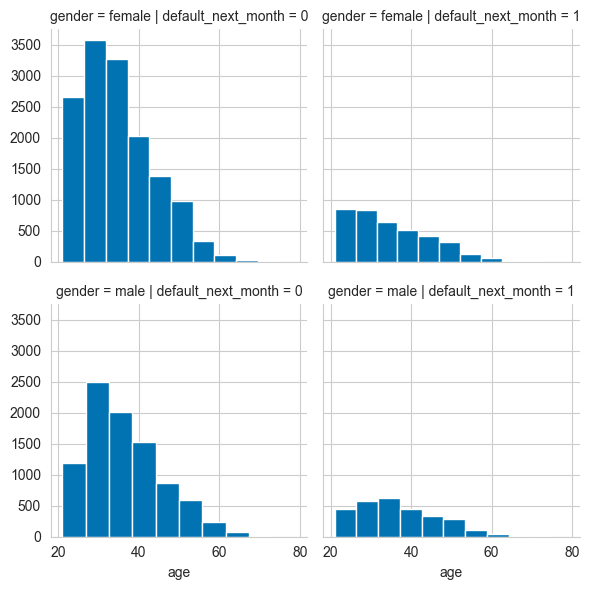

In [40]:
g = sns.FacetGrid(df, col="default_next_month", row="gender")
g.map(plt.hist, "age")

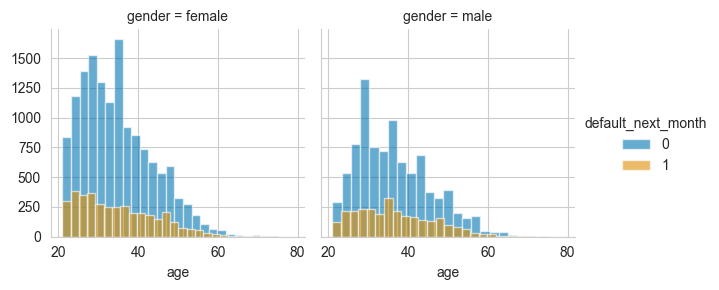

In [41]:
g = sns.FacetGrid(df, col="gender", hue="default_next_month")
g.map(plt.hist, "age", alpha=0.6, bins=25)
g.add_legend()

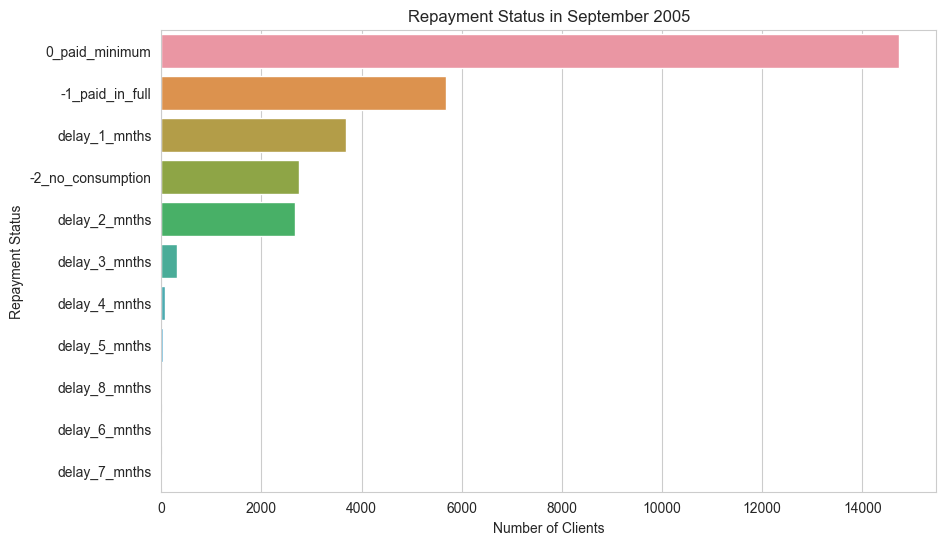

In [42]:
# Repayment Status Frequency for Recent Month (September)
plt.figure(figsize=(10, 6))
sns.barplot(y="repay_status_sep", x="count", data=df["repay_status_sep"].value_counts().reset_index())
plt.title("Repayment Status in September 2005")
plt.xlabel("Number of Clients")
plt.ylabel("Repayment Status")
plt.show()

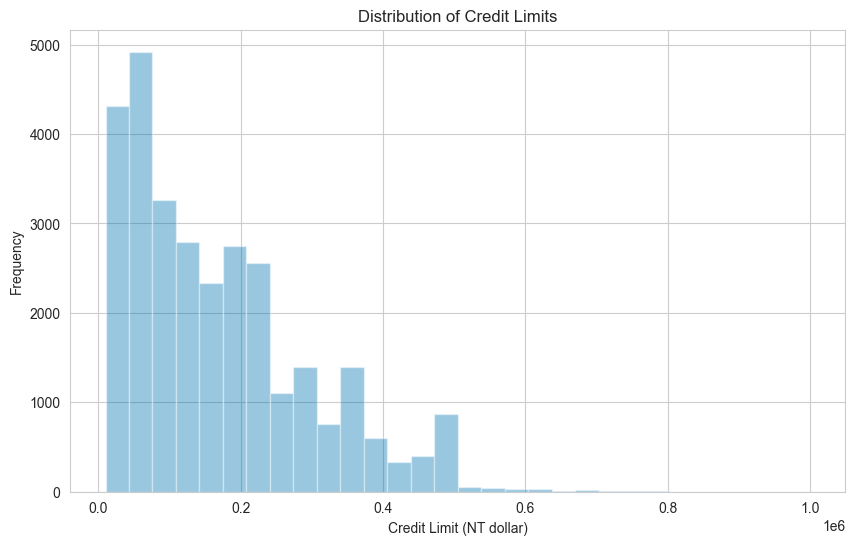

In [43]:
# 1. Distribution of Credit Limits
plt.figure(figsize=(10, 6))
sns.distplot(df["credit_limit"], bins=30, kde=False)
plt.title("Distribution of Credit Limits")
plt.xlabel("Credit Limit (NT dollar)")
plt.ylabel("Frequency")
plt.show()

## Feature Engineering

### Convert age column to categorical bins

Bin ages according to business context and reflect different life stages and financial behaviours typically associated with them. It's important to consider how financial stability, credit behavior, and risk of default might vary across different age groups. 

Following age groupings have been chosen:

1. **Young Adults (21-25):** This group often includes college students and young professionals who are just starting their careers. They might have a higher propensity for risk-taking and may lack a long credit history, which could affect their default risk.

2. **Emerging Professionals (26-35):** Individuals in this group are generally settling into their careers and might be looking at major life investments like buying a home or starting a family. Their financial behavior can be quite varied, with some being quite stable and others still struggling with debt.

3. **Established Adults (36-50):** This group typically includes individuals with more stable and established careers. They might have higher credit limits and a more extensive credit history but could also have higher expenses related to family and homeownership.

4. **Pre-Retirement (51-65):** These individuals are often planning for retirement and may have more assets and savings. However, they could also be dealing with significant expenses like children's college fees or healthcare costs.

5. **Retirees (65+):** Post-retirement age, individuals might have a reduced income but potentially substantial savings. Their spending and credit use patterns can significantly differ from those of younger individuals.

In [44]:
# Define age bins and labels based on the suggested age groups
age_bins = [
    0,
    25,
    35,
    50,
    65,
    100,
]
age_labels = ["21-25", "26-35", "36-50", "51-65", "66+"]

In [45]:
df["age_group"] = pd.cut(
    df["age"],
    bins=age_bins,
    labels=age_labels,
    right=False,
    include_lowest=True,
)

In [46]:
df.groupby("age_group")["default_next_month"].mean()

age_group
21-25    0.271881
26-35    0.202982
36-50    0.222557
51-65    0.252918
66+      0.254545
Name: default_next_month, dtype: float64

In [47]:
df["marital_gender"] = df["marital_status"] + "_" + df["gender"]
df["education_gender"] = df["education_level"] + "_" + df["gender"]
df["education_marital"] = df["education_level"] + "_" + df["marital_status"]
df["education_marital_gender"] = (
    df["education_level"] + "_" + df["marital_status"] + "_" + df["gender"]
)

In [70]:
result = (
    df.groupby("marital_gender")["default_next_month"]
    .mean()
    .reset_index()
    .sort_values(by="default_next_month", ascending=False)
)
result

,marital_gender,default_next_month
3,others_male,0.289655
1,married_male,0.259345
5,single_male,0.226614
0,married_female,0.219625
2,others_female,0.202586
4,single_female,0.197216


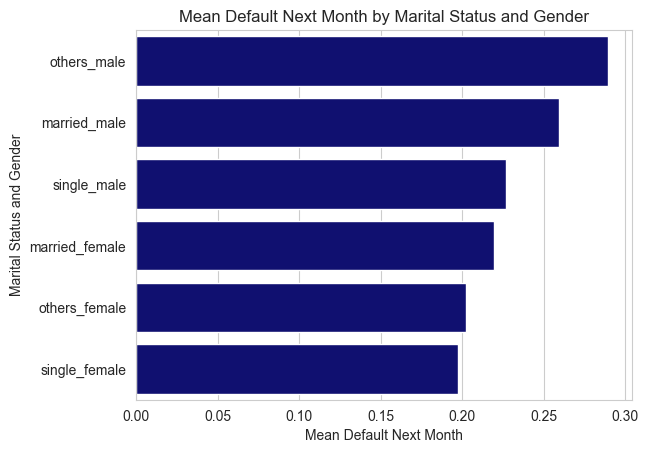

In [71]:
sns.barplot(x="default_next_month", y="marital_gender", data=result, color="navy")
plt.xlabel("Mean Default Next Month")
plt.ylabel("Marital Status and Gender")
plt.title("Mean Default Next Month by Marital Status and Gender")
plt.show()

In [67]:
result = (
    df.groupby("education_gender")["default_next_month"]
    .mean()
    .reset_index()
    .sort_values(by="default_next_month", ascending=False)
)
result

,education_gender,default_next_month
3,high_school_male,0.273869
7,university_male,0.262002
2,high_school_female,0.236420
6,university_female,0.222043
1,graduate_school_male,0.208085
0,graduate_school_female,0.181351
5,others_male,0.095238
9,unknown_male,0.078125
8,unknown_female,0.073733
4,others_female,0.037037


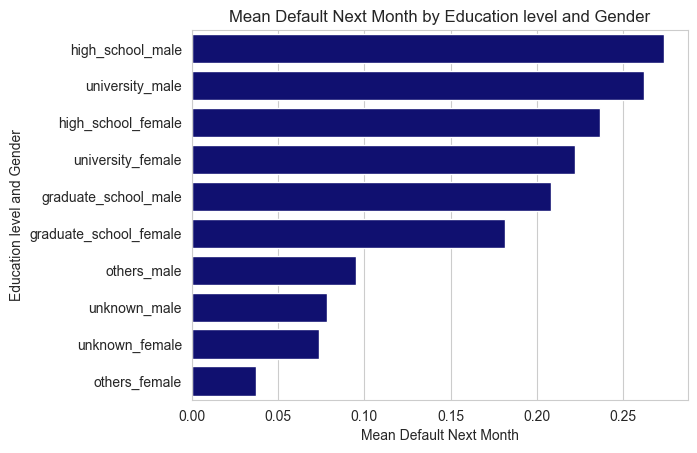

In [68]:
sns.barplot(x="default_next_month", y="education_gender", data=result, color="navy")
plt.xlabel("Mean Default Next Month")
plt.ylabel("Education level and Gender")
plt.title("Mean Default Next Month by Education level and Gender")
plt.show()

In [73]:
result = (
    df.groupby("education_marital")["default_next_month"]
    .mean()
    .reset_index()
    .sort_values(by="default_next_month", ascending=False)
)
result

,education_marital,default_next_month
10,university_others,0.267857
3,high_school_married,0.263544
9,university_married,0.243496
1,graduate_school_others,0.240741
5,high_school_single,0.236773
11,university_single,0.230627
4,high_school_others,0.210884
0,graduate_school_married,0.206609
2,graduate_school_single,0.184168
12,unknown_married,0.076923


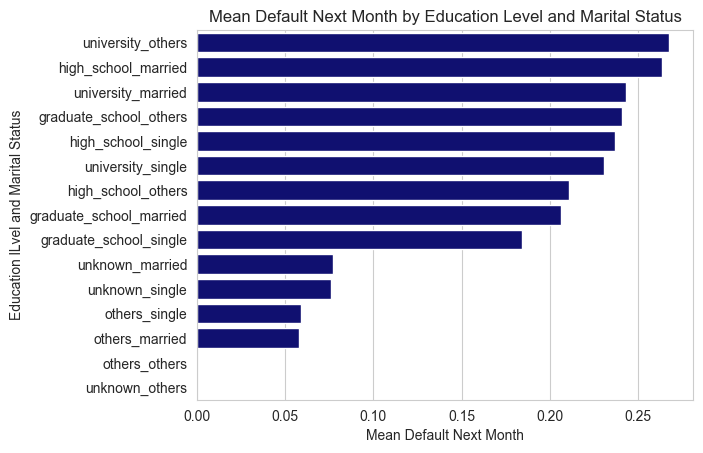

In [74]:
sns.barplot(x="default_next_month", y="education_marital", data=result, color="navy")
plt.xlabel("Mean Default Next Month")
plt.ylabel("Education Level and Marital Status")
plt.title("Mean Default Next Month by Education Level and Marital Status")
plt.show()

In [75]:
result = (
    df.groupby("education_marital_gender")["default_next_month"]
    .mean()
    .reset_index()
    .sort_values(by="default_next_month", ascending=False)
)
result

,education_marital_gender,default_next_month
3,graduate_school_others_male,0.322581
21,university_others_male,0.296875
7,high_school_married_male,0.289122
19,university_married_male,0.271308
9,high_school_others_male,0.270833
11,high_school_single_male,0.256152
23,university_single_male,0.253741
20,university_others_female,0.250000
6,high_school_married_female,0.248759
1,graduate_school_married_male,0.230769


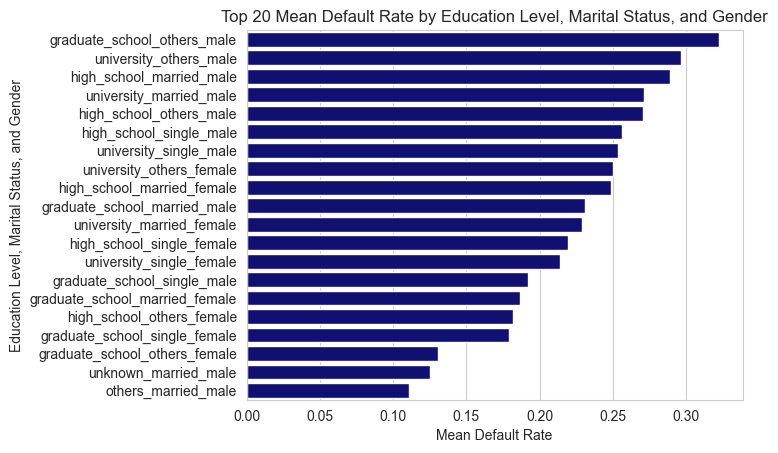

In [77]:
sns.barplot(
    x="default_next_month", y="education_marital_gender", data=result.head(20), color="navy"
)
plt.xlabel("Mean Default Rate")
plt.ylabel("Education Level, Marital Status, and Gender")
plt.title("Top 20 Mean Default Rate by Education Level, Marital Status, and Gender")
plt.show()

In [52]:
df["repay_label_sum"] = (
    df["repay_label_sep"]
    + df["repay_label_aug"]
    + df["repay_label_jul"]
    + df["repay_label_jun"]
    + df["repay_label_may"]
    + df["repay_label_apr"]
)

In [53]:
df.groupby("default_next_month")["repay_label_sum"].mean()

default_next_month
0   -1.980140
1    2.023056
Name: repay_label_sum, dtype: float64

In [54]:
df.groupby("repay_label_sum")["default_next_month"].mean()

repay_label_sum
-12    0.134661
-11    0.193182
-10    0.174061
-9     0.302191
-8     0.159509
-7     0.148562
-6     0.143029
-5     0.153629
-4     0.157352
-3     0.168709
-2     0.154059
-1     0.145740
 0     0.110871
 1     0.325503
 2     0.337228
 3     0.347626
 4     0.472803
 5     0.421053
 6     0.580000
 7     0.504373
 8     0.646817
 9     0.500000
 10    0.621118
 11    0.544892
 12    0.753744
 13    0.772414
 14    0.632911
 15    0.800000
 16    0.770833
 17    0.800000
 18    0.681818
 19    0.727273
 20    0.500000
 21    0.400000
 22    0.333333
 23    0.000000
 24    0.666667
 25    0.666667
 26    1.000000
 27    0.833333
 28    0.888889
 29    1.000000
 30    0.000000
 31    0.666667
 32    0.800000
 33    0.578947
 36    1.000000
Name: default_next_month, dtype: float64

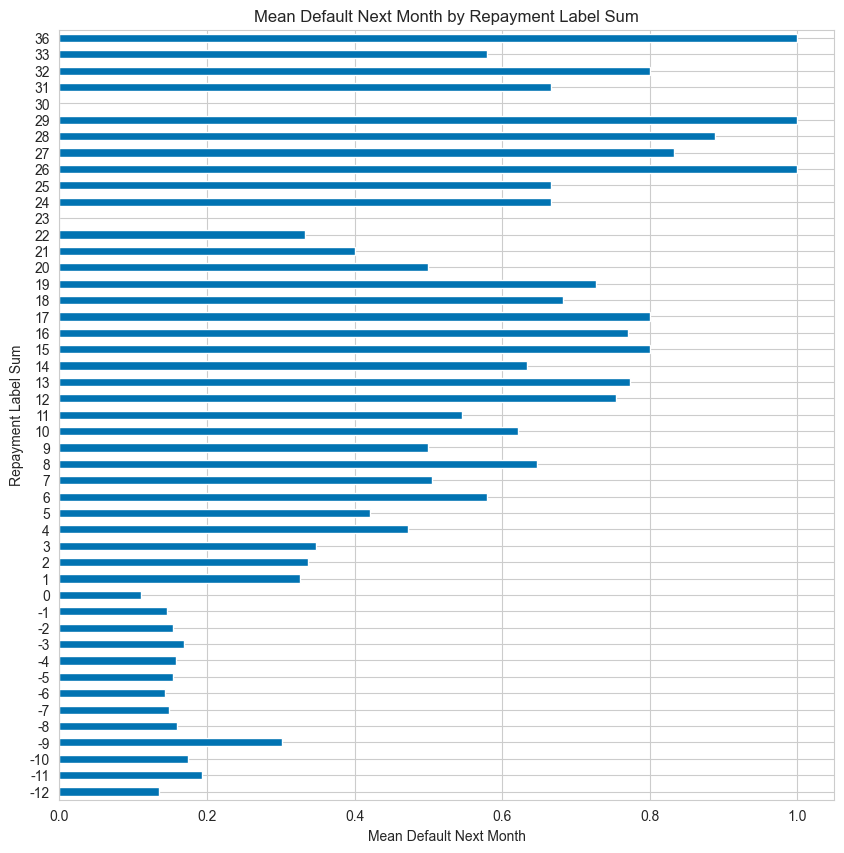

In [55]:
plt.figure(figsize=(10, 10))
df.groupby("repay_label_sum")["default_next_month"].mean().plot(kind='barh')
plt.title("Mean Default Next Month by Repayment Label Sum")
plt.xlabel("Mean Default Next Month")
plt.ylabel("Repayment Label Sum")
plt.show()

In [56]:
# Flag of count of times a customer has missed a payment
pay_columns = [
    "repay_label_sep",
    "repay_label_aug",
    "repay_label_jul",
    "repay_label_jun",
    "repay_label_may",
    "repay_label_apr",
]


def count_delayed_payments(row):
    return sum(1 for pay in row[pay_columns] if 1 <= pay <= 9)


# Apply the function to each row of the DataFrame
df["count_of_delayed_payments"] = df.apply(count_delayed_payments, axis=1)

In [57]:
# Display the first few rows of the DataFrame to verify the new column
pay_columns_check = [
    "repay_label_sep",
    "repay_label_aug",
    "repay_label_jul",
    "repay_label_jun",
    "repay_label_may",
    "repay_label_apr",
    "count_of_delayed_payments",
    "default_next_month",
]
df[pay_columns_check].head()

,repay_label_sep,repay_label_aug,repay_label_jul,repay_label_jun,repay_label_may,repay_label_apr,count_of_delayed_payments,default_next_month
0,2,2,-1,-1,-2,-2,2,1
1,-1,2,0,0,0,2,2,1
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,-1,0,-1,0,0,0,0,0


In [58]:
df.groupby("count_of_delayed_payments")["default_next_month"].mean()

count_of_delayed_payments
0    0.117104
1    0.298238
2    0.387572
3    0.508666
4    0.573081
5    0.573826
6    0.703207
Name: default_next_month, dtype: float64

In [59]:
df.groupby("default_next_month")["count_of_delayed_payments"].mean()

default_next_month
0    0.504194
1    1.996082
Name: count_of_delayed_payments, dtype: float64

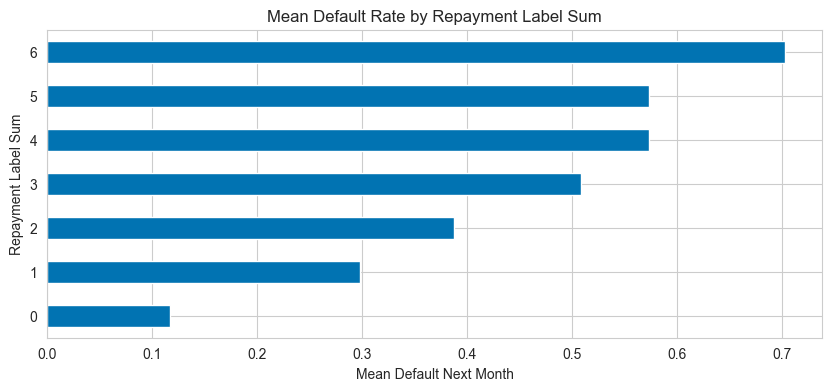

In [78]:
plt.figure(figsize=(10, 4))
df.groupby("count_of_delayed_payments")["default_next_month"].mean().plot(kind="barh")
plt.title("Mean Default Rate by Repayment Label Sum")
plt.xlabel("Mean Default Next Month")
plt.ylabel("Repayment Label Sum")
plt.show()

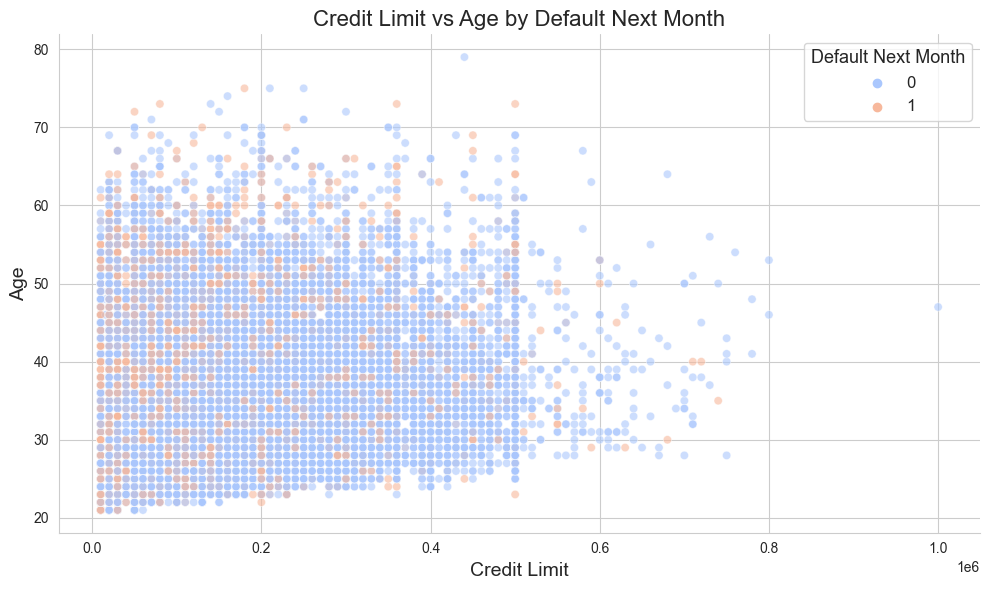

In [ ]:
# Create a seaborn plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="credit_limit",
    y="age",
    hue="default_next_month",
    data=df,
    palette="coolwarm",
    alpha=0.6,
)
plt.title("Credit Limit vs Age by Default Next Month", fontsize=16)
plt.xlabel("Credit Limit", fontsize=14)
plt.ylabel("Age", fontsize=14)
plt.legend(title="Default Next Month", title_fontsize="13", fontsize="12")
sns.despine()  # Removes the top and right border of the plot
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping

# Show the plot
plt.show()

## 